In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Set Plotting Defaults

In [592]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from src.parameters import FIGURE_DIR

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 9,
    'text.color': '#222222',
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

is_save_figures = True

In [6]:
def save_figure(figure_name, is_save_figures):
    if is_save_figures:
        figure_name = os.path.join(FIGURE_DIR, figure_name)
        plt.savefig(figure_name + '.pdf', transparent=True, dpi=300, bbox_inches='tight')

## Simulate Sorted Spikes Data

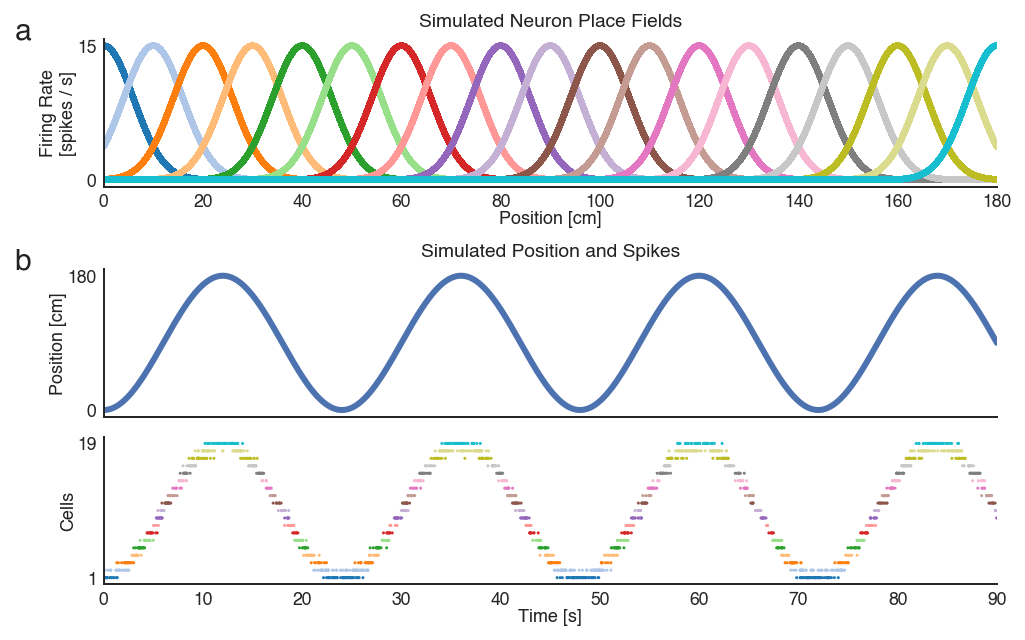

tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 5 memory: 82 MB fds: 203>>
Traceback (most recent call last):
  File "/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/tornado/ioloop.py", line 907, in _run
    return self.callback()
  File "/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/system_monitor.py", line 67, in update
    read_bytes = (ioc.bytes_recv - last.bytes_recv) / (duration or 0.5)
AttributeError: 'NoneType' object has no attribute 'bytes_recv'


In [615]:
from src.sorted_spikes_simulation import make_simulated_run_data
from src.figure_utilities import TWO_COLUMN, GOLDEN_RATIO

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

fig, axes = plt.subplots(3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True)
for place_field, color in zip(place_fields.T, cmap.colors):
    axes[0].plot(linear_distance, place_field, linewidth=3, color=color)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('Simulated Place Fields')
axes[0].set_xlim((linear_distance.min(), linear_distance.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])
axes[0].text(-0.10, 1.0, 'a', transform=axes[0].transAxes, 
        size=15, weight='extra bold')

axes[1].plot(time, linear_distance, linewidth=3)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(linear_distance.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))
axes[1].text(-0.10, 1.0, 'b', transform=axes[1].transAxes, 
        size=15, weight='extra bold')

c = [cmap.colors[ind] for ind in neuron_ind]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel('Cells')

axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

# save_figure('Figure2', is_save_figures)

## Fit Sorted Spikes Classifier

In [73]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    spike_model_penalty=0.5,
                                    place_bin_size=np.sqrt(movement_var))
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform', 'identity'], ['uniform', 'uniform', 'uniform'], ['random_walk', 'uniform', 'identity']],
            discrete_transition_diag=0.999,
            discrete_transition_type='strong_diagonal',
            infer_track_interior=True,
            initial_conditions_type='uniform_on_track', knot_spacing=10,
            movement_var=0.2775841643294233,
            place_bin_size=0.526862566832588, position_range=None,
            replay_speed=120, spike_model_penalty=0.5)

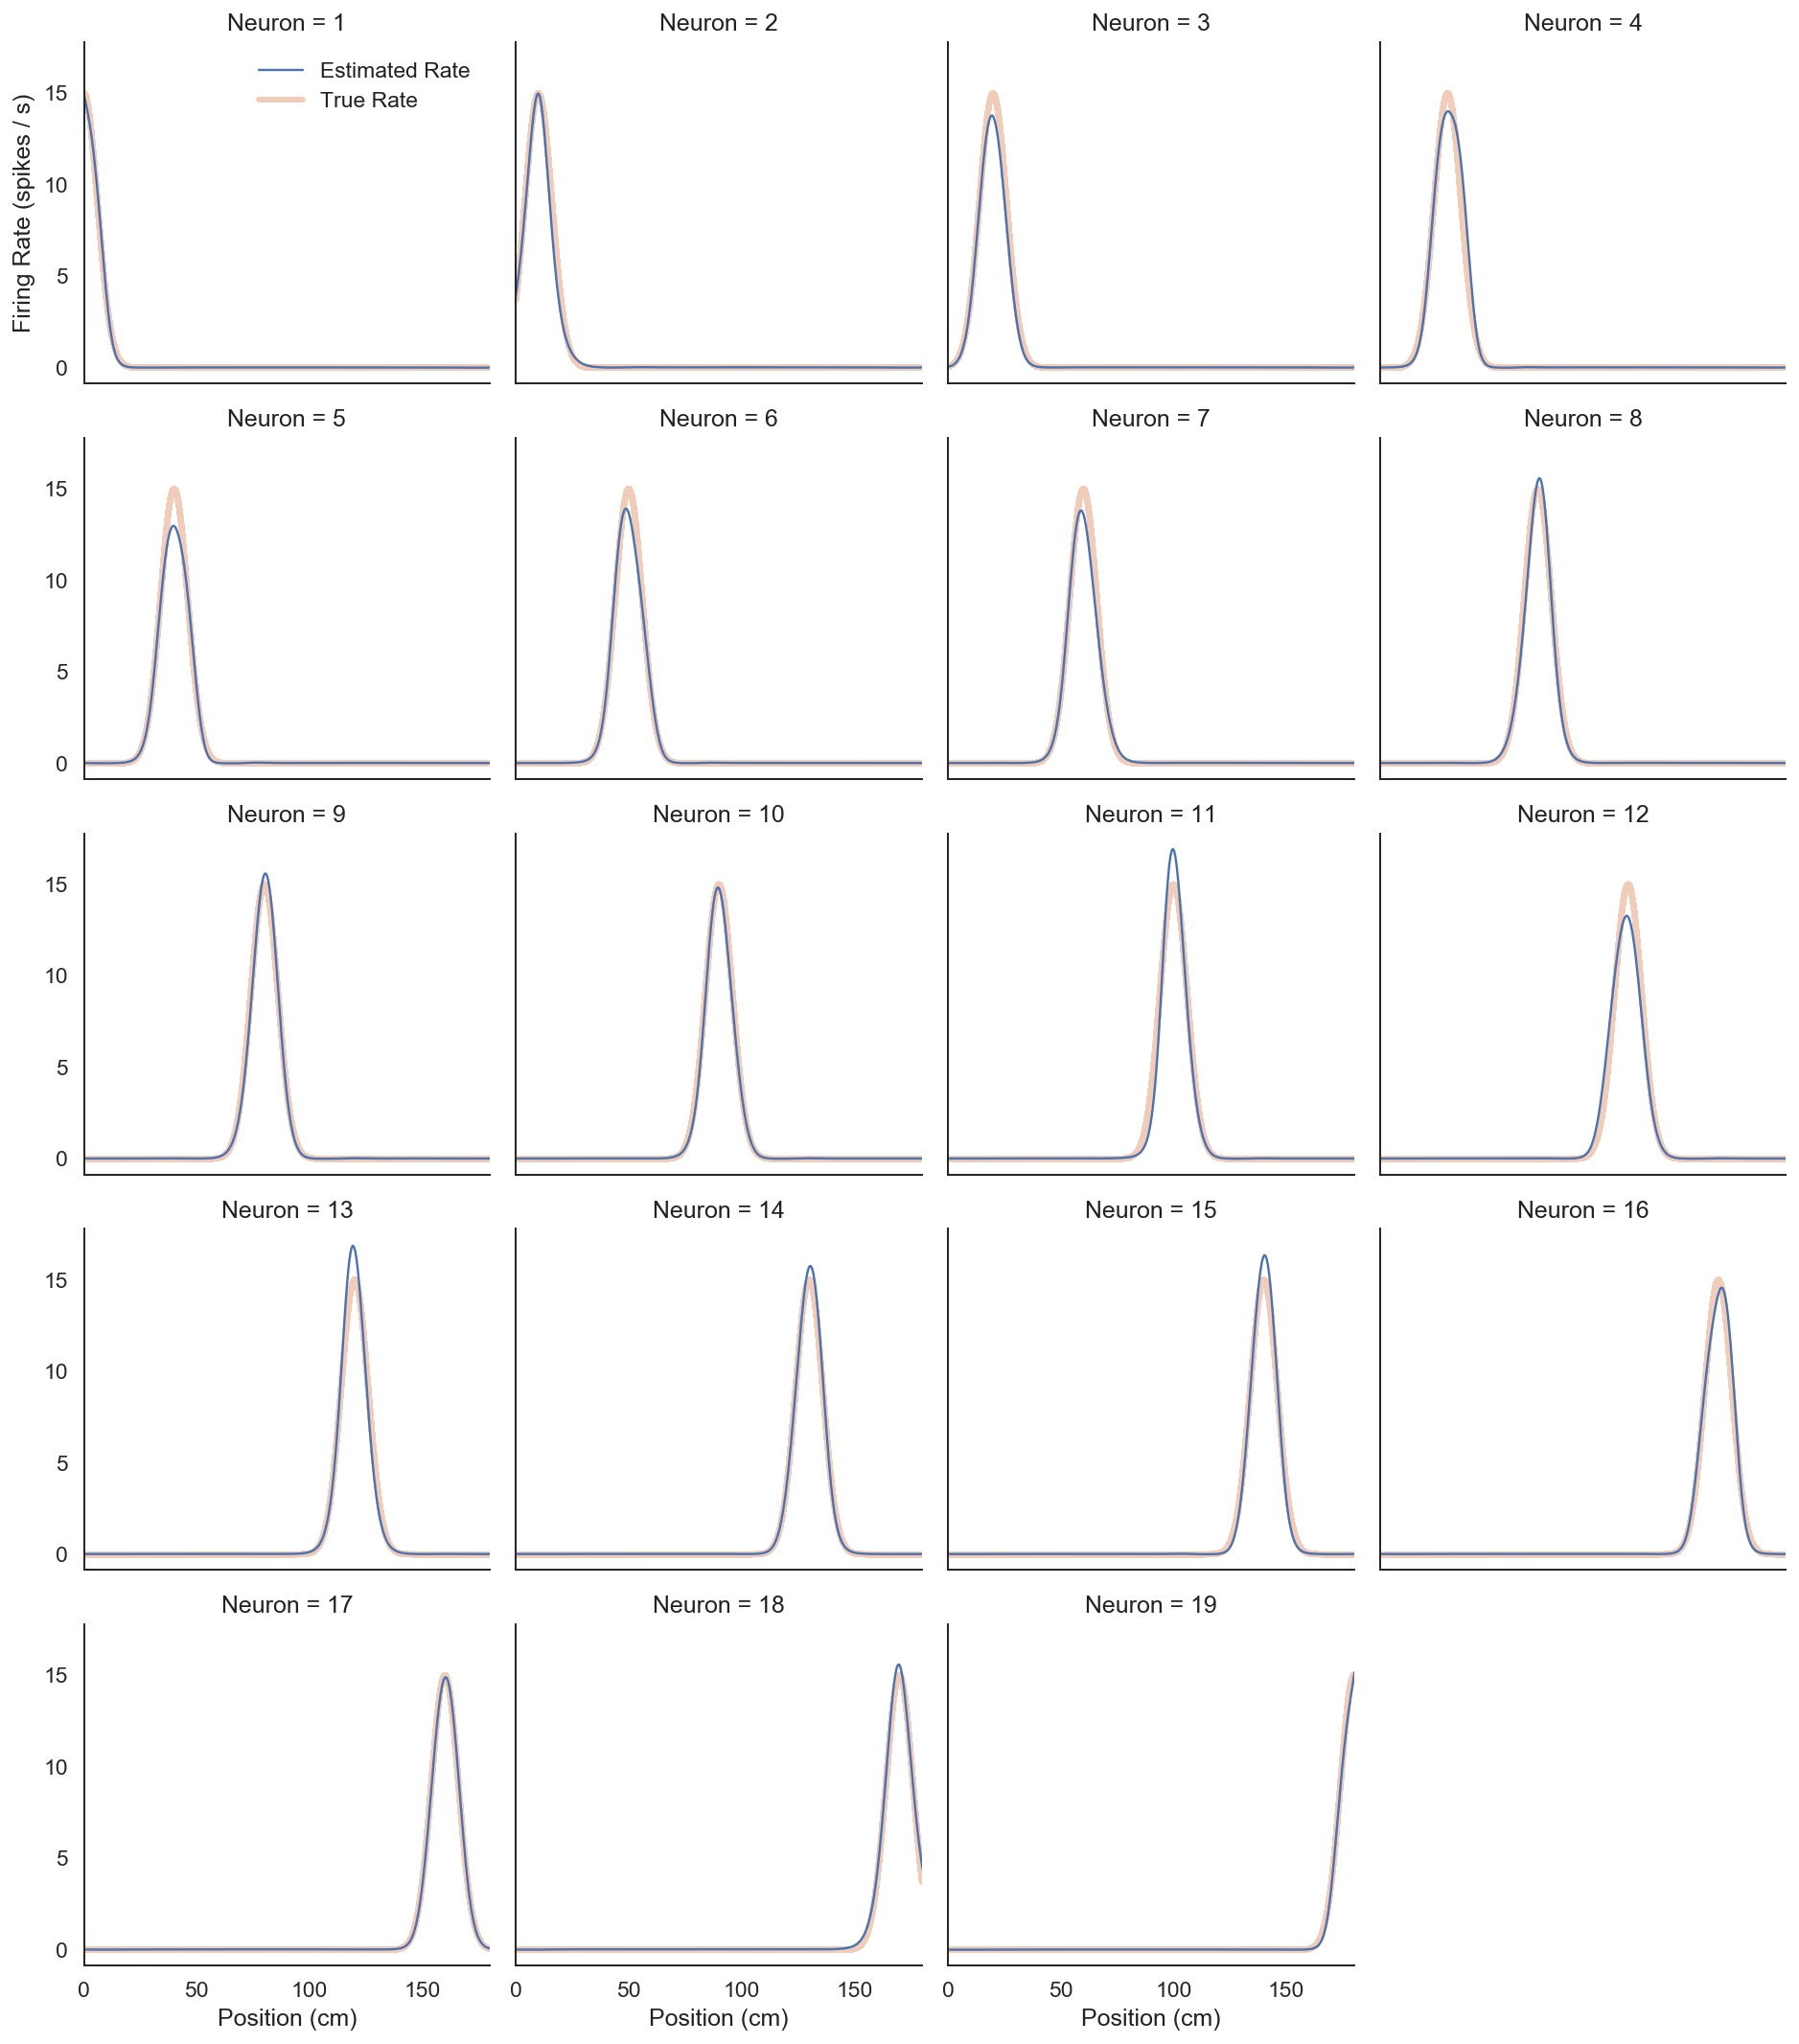

In [9]:
g = (classifier.place_fields_ * sampling_frequency).plot(x='position', col='neuron', col_wrap=4, label='Estimated Rate')
for ind, (ax, true_field) in enumerate(zip(g.axes.flat, place_fields.T)):
    ax.plot(linear_distance, true_field, linestyle='-',
            zorder=0, linewidth=3, alpha=0.4, label='True Rate')
    ax.set_xlim((linear_distance.min(), linear_distance.max()))
    ax.set_title(f'Neuron = {ind + 1}')
sns.despine()

g.axes[0, 0].set_ylabel('Firing Rate (spikes / s)')
g.axes[0, 0].legend(frameon=False)

for ax in g.axes[-1]:
    ax.set_xlabel('Position (cm)')

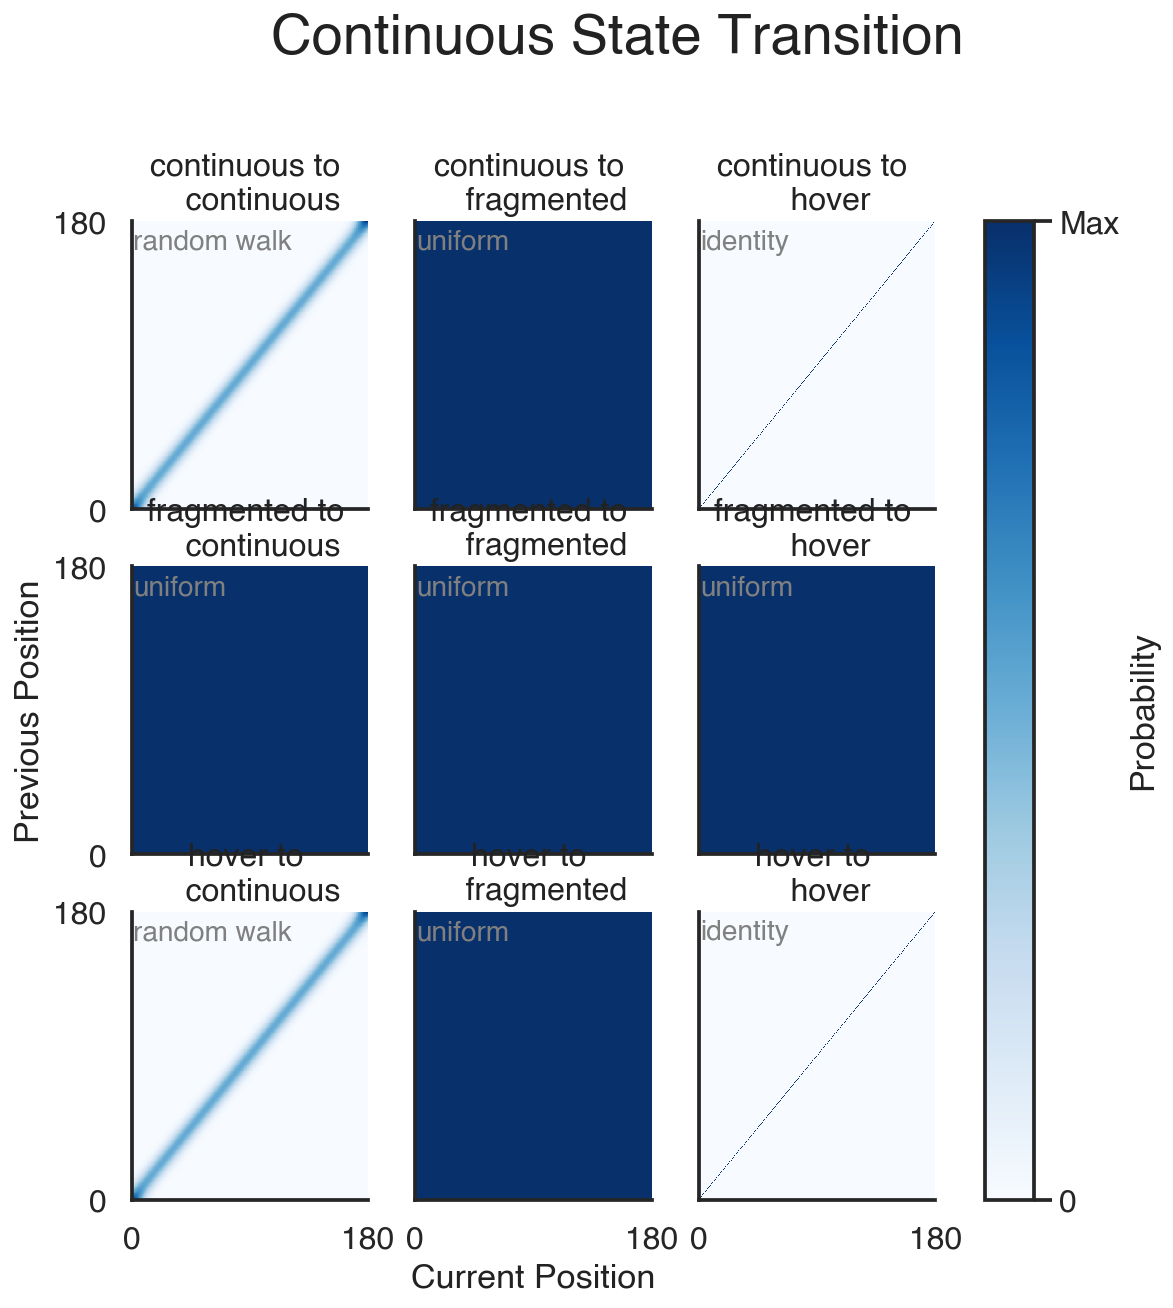

In [167]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9),
                         sharex=True, sharey=True)
continuous_transition_types = np.asarray(classifier.continuous_transition_types)
x, y = np.meshgrid(classifier.place_bin_edges_, classifier.place_bin_edges_)
state_names = ['continuous', 'fragmented', 'hover']
bin_min, bin_max = linear_distance.min(), linear_distance.max()

for j in range(3):
    for k in range(3):
        im = axes[j, k].pcolormesh(x, y, classifier.continuous_state_transition_[j, k], cmap='Blues',
                                   vmin=0.0, vmax=classifier.continuous_state_transition_[j, k].max())
        axes[j, k].text(1, 175, continuous_transition_types[j, k].replace('_', ' '), color='grey',
                        va='top', fontsize=14)
        axes[j, k].set_title(f'{state_names[j]} to\n\t {state_names[k]}')
        axes[j, k].set_xticks((bin_min, bin_max))
        axes[j, k].set_yticks((bin_min, bin_max))
        
plt.xlim((bin_min, bin_max))
plt.ylim((bin_min, bin_max))
axes[1, 0].set_ylabel('Previous Position')
axes[-1, 1].set_xlabel('Current Position')
plt.suptitle('Continuous State Transition', y=1.04)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), ticks=[0, 1], label='Probability')
cbar.ax.set_yticklabels(['0', 'Max'])
sns.despine()

save_figure('simulated_spikes_continuous_state_transition', is_save_figures)

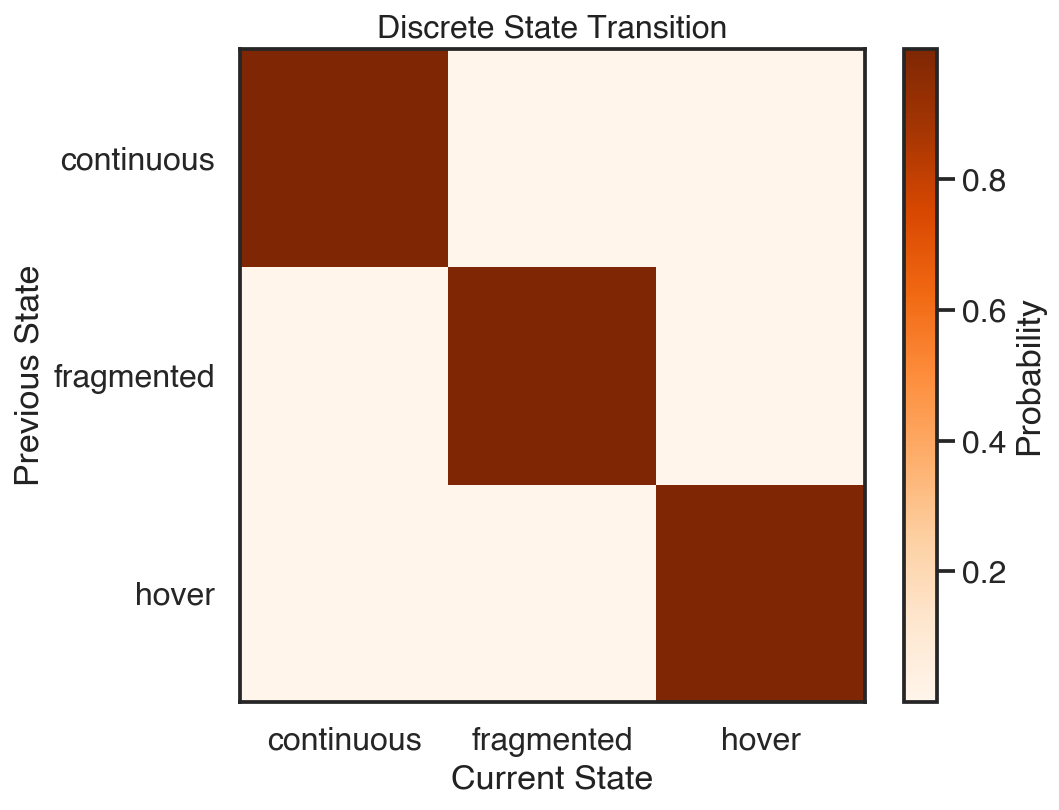

In [165]:
state_names = ['continuous', 'fragmented', 'hover']
edges = np.arange(0.5, 4.5)
x_edges, y_edges = np.meshgrid(edges, edges)
plt.figure(figsize=(7, 6))
plt.pcolormesh(x_edges, y_edges, np.fliplr(classifier.discrete_state_transition_), cmap='Oranges')
plt.xticks(ticks=range(1, 4), labels=state_names)
plt.yticks(ticks=range(1, 4), labels=state_names[::-1])
plt.colorbar(label='Probability')
plt.ylabel('Previous State')
plt.xlabel('Current State')
plt.title('Discrete State Transition')

save_figure('simulated_spikes_discrete_state_transition', is_save_figures)

## Test classifier on different replay types 

In [124]:
from src.parameters import TRANSITION_TO_CATEGORY, STATE_COLORS

def plot_classification(replay_time, test_spikes, results):
    results = results.assign_coords(
        state=lambda ds: ds.state.to_index()
        .map(TRANSITION_TO_CATEGORY))
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=4, label=state, color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
#     axes[1].legend(bbox_to_anchor=(1.15, 0.95), loc='upper right', fancybox=False, shadow=False,
#                    ncol=1, frameon=False)
    
    results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    sns.despine()

### Continuous

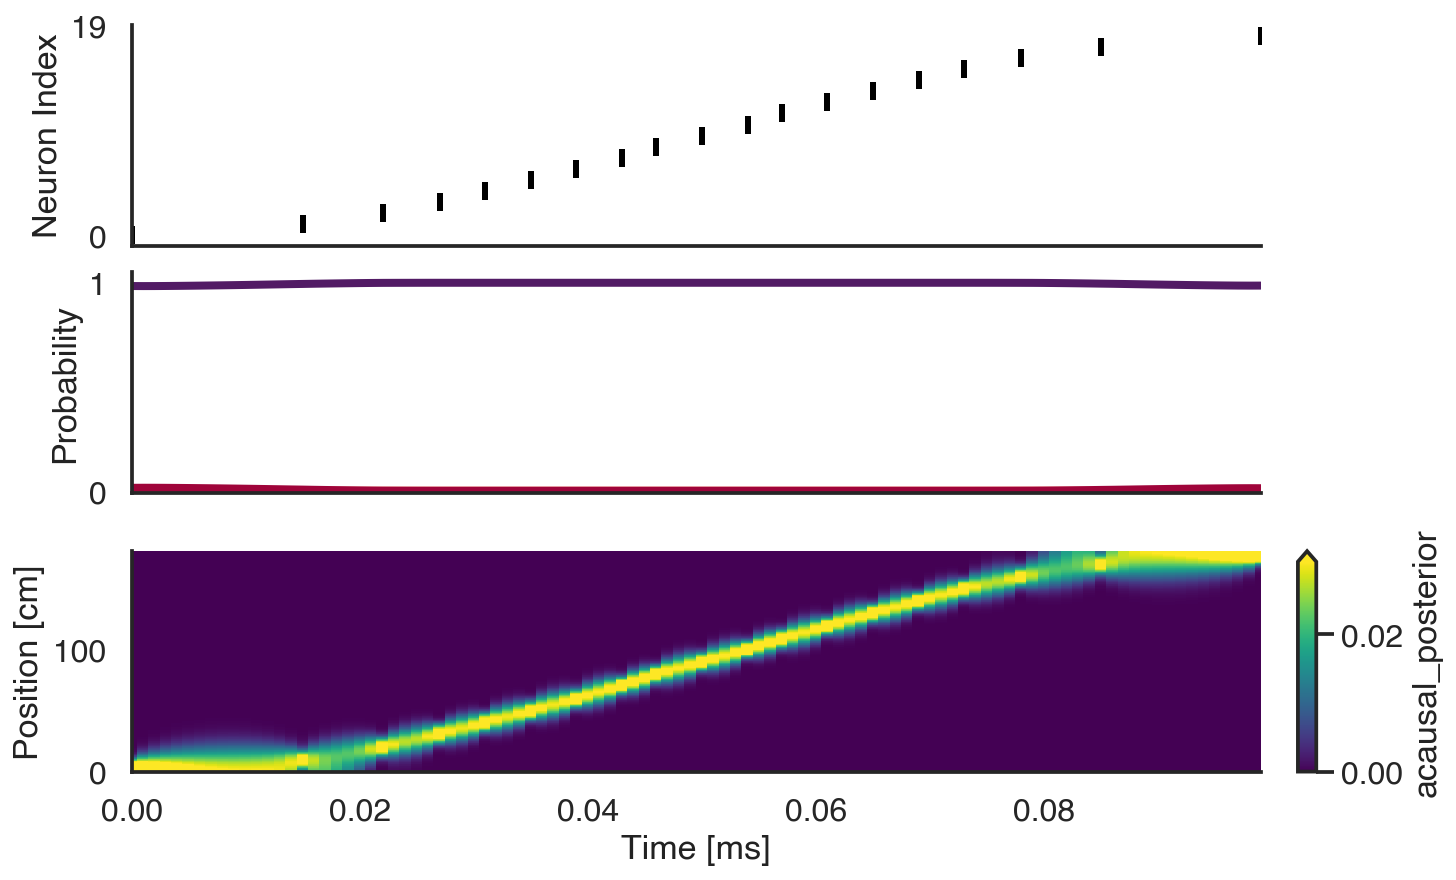

In [125]:
from src.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)
save_figure('simulated_spikes_continuous_replay', is_save_figures)

### Hover

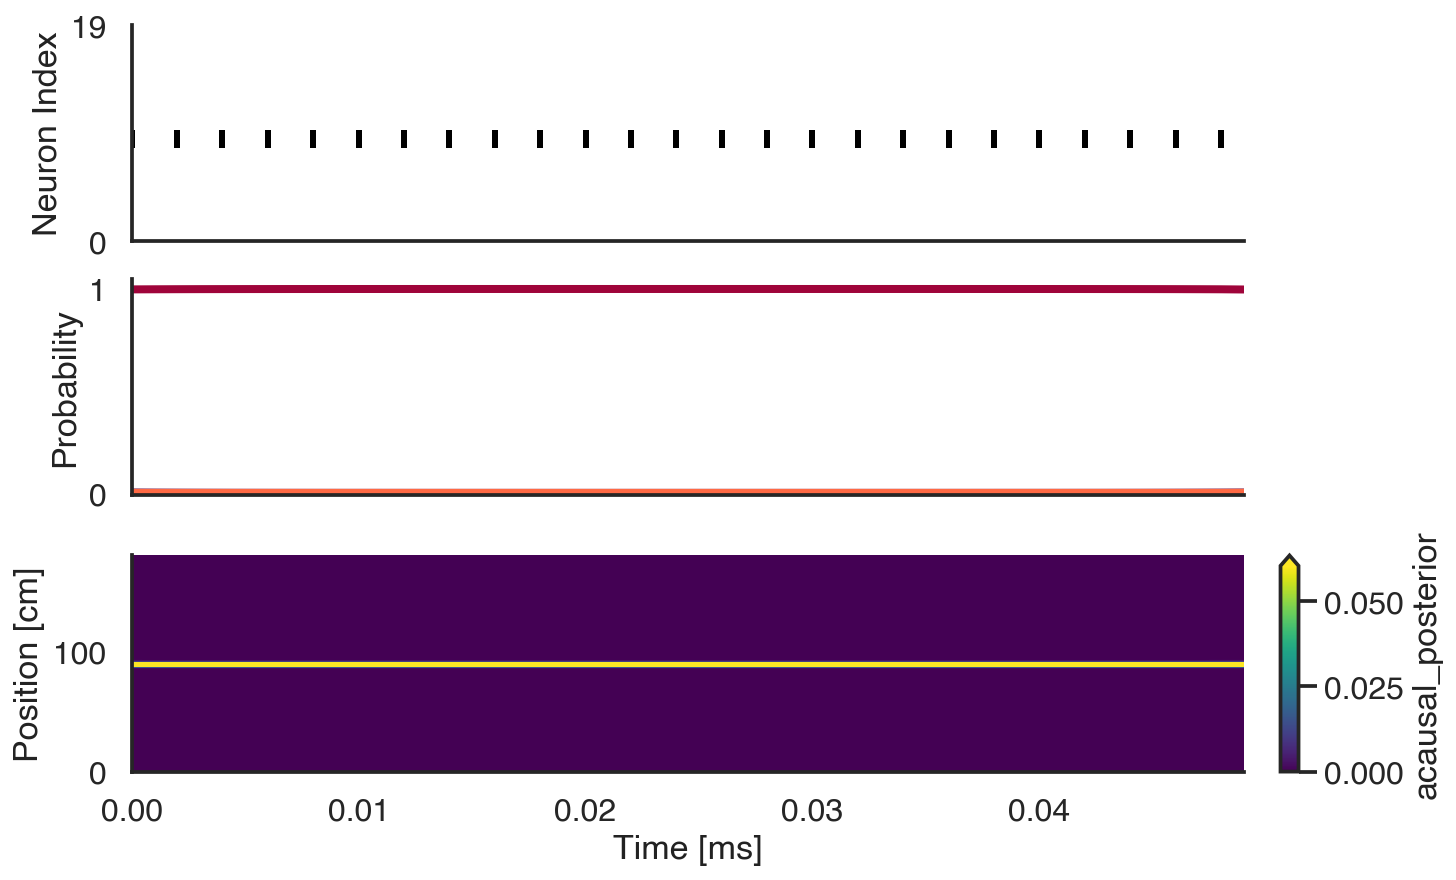

In [126]:
from src.sorted_spikes_simulation import make_hover_replay

replay_time, test_spikes = make_hover_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)
save_figure('simulated_spikes_hover_replay', is_save_figures)

### Fragmented

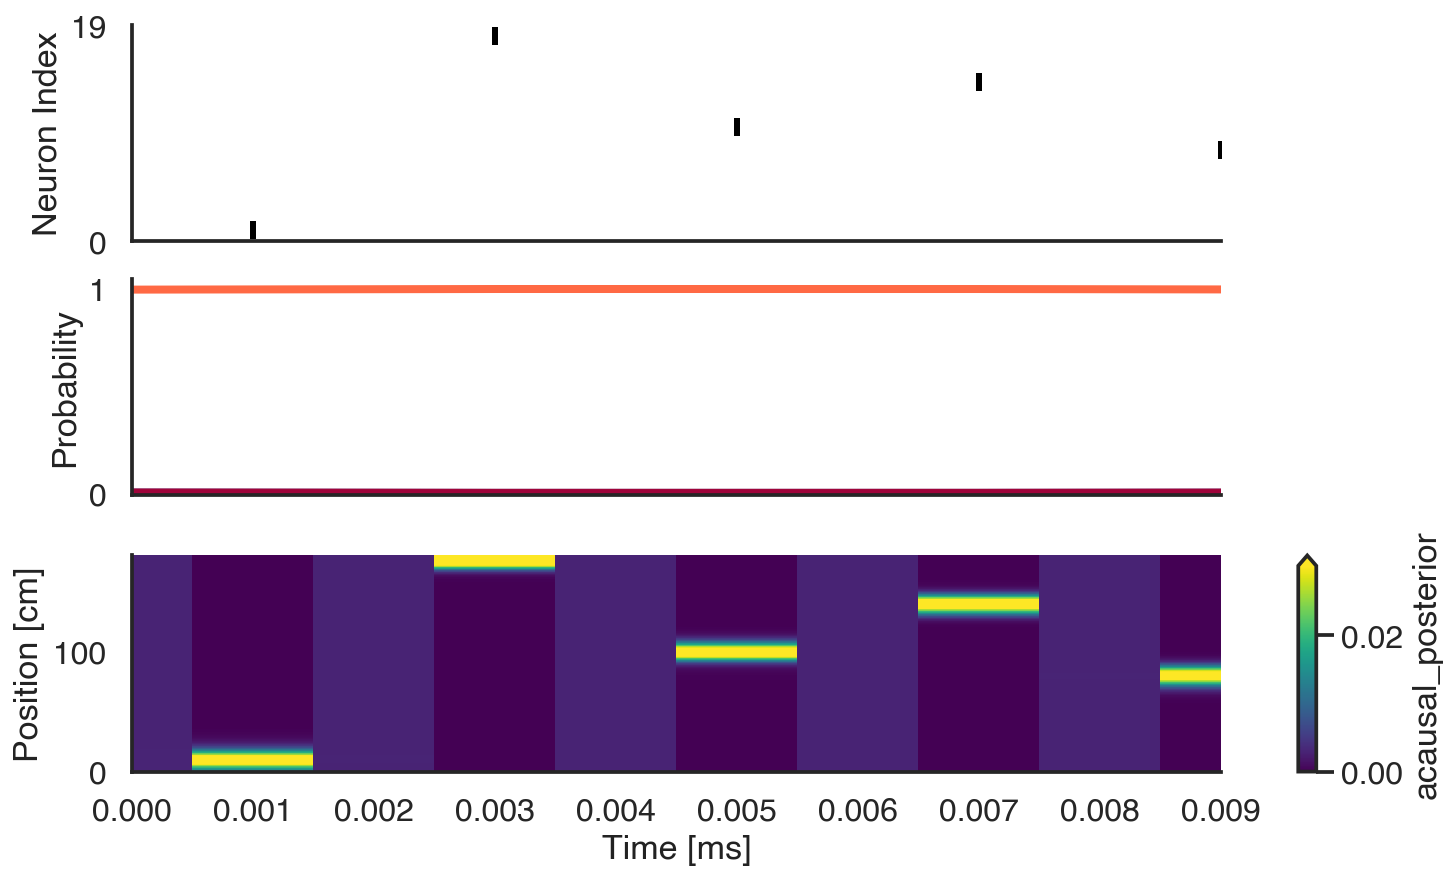

In [128]:
from src.sorted_spikes_simulation import make_fragmented_replay

replay_time, test_spikes = make_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)

save_figure('simulated_spikes_fragmented_replay', is_save_figures)

### Hover-Continuous-Hover 

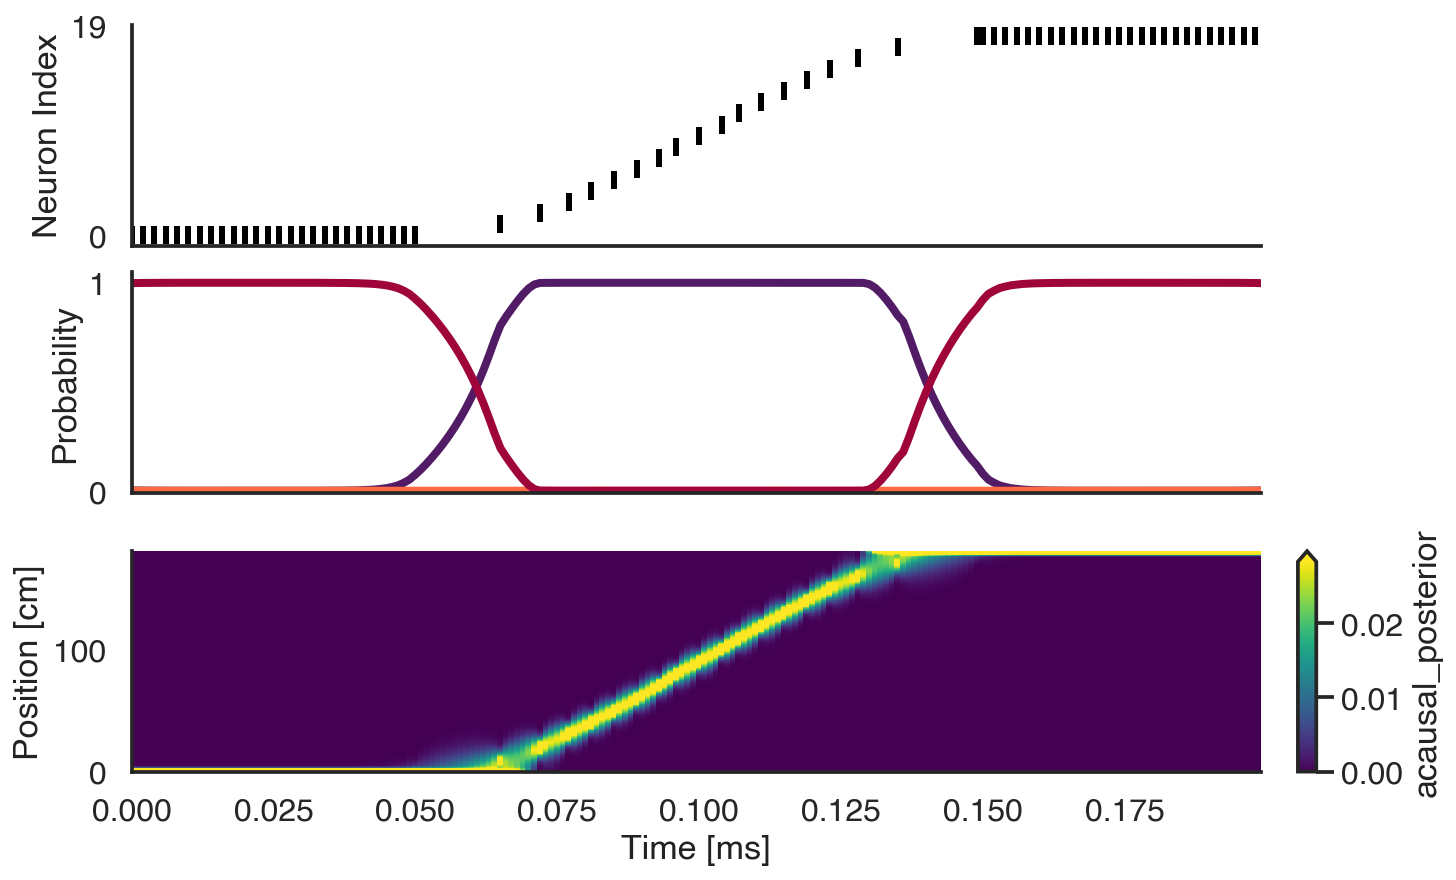

In [129]:
from src.sorted_spikes_simulation import make_hover_continuous_hover_replay

replay_time, test_spikes = make_hover_continuous_hover_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)

save_figure('simulated_spikes_hover_continuous_hover_replay', is_save_figures)

### Fragmented-Hover-Fragmented

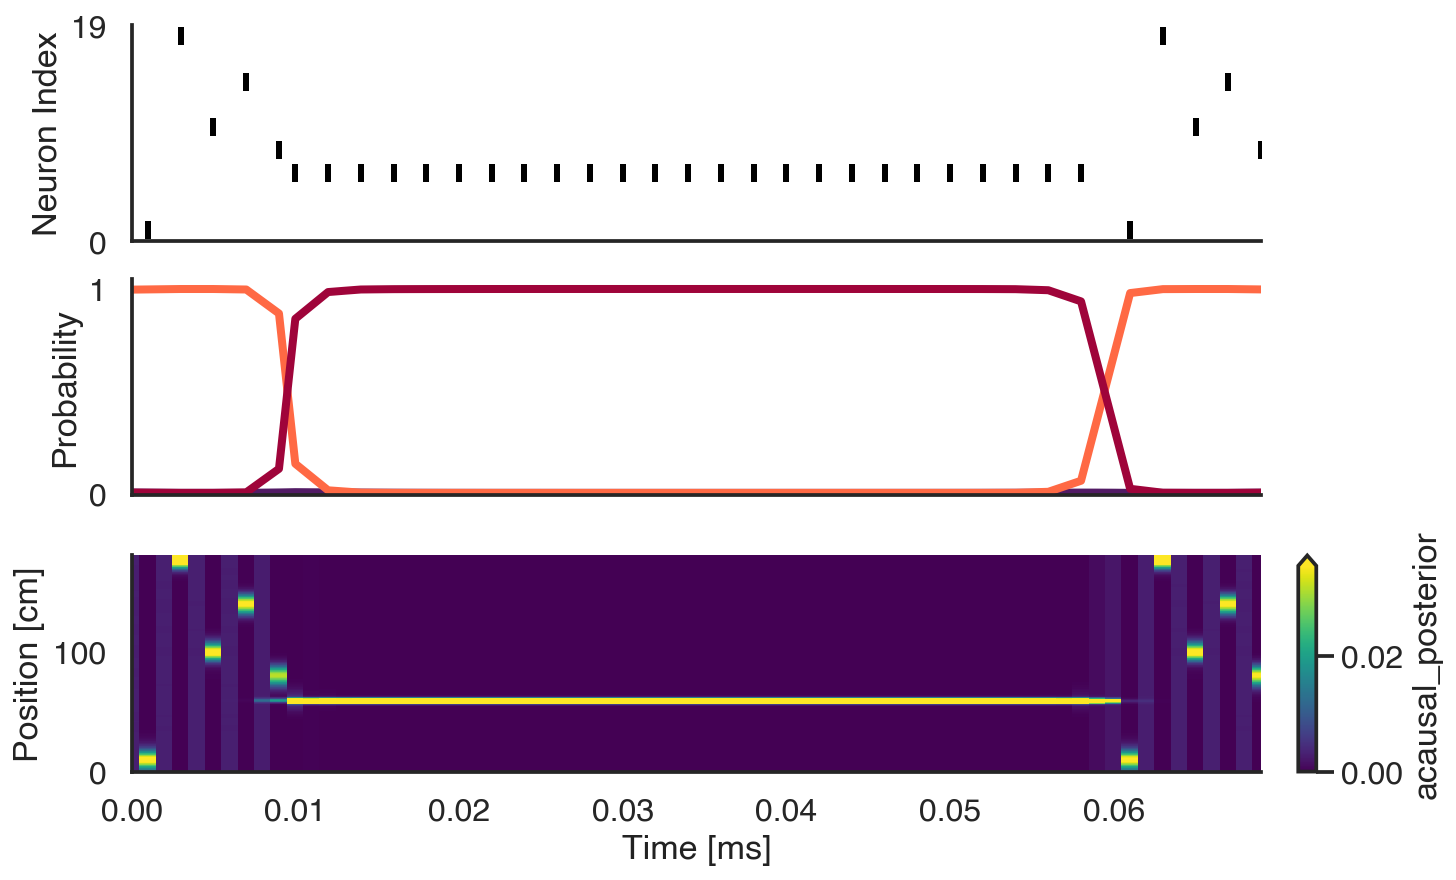

In [130]:
from src.sorted_spikes_simulation import make_fragmented_hover_fragmented_replay

replay_time, test_spikes = make_fragmented_hover_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)

save_figure('simulated_spikes_fragmented_hover_fragmented_replay', is_save_figures)

### Fragmented-Continuous-Fragmented

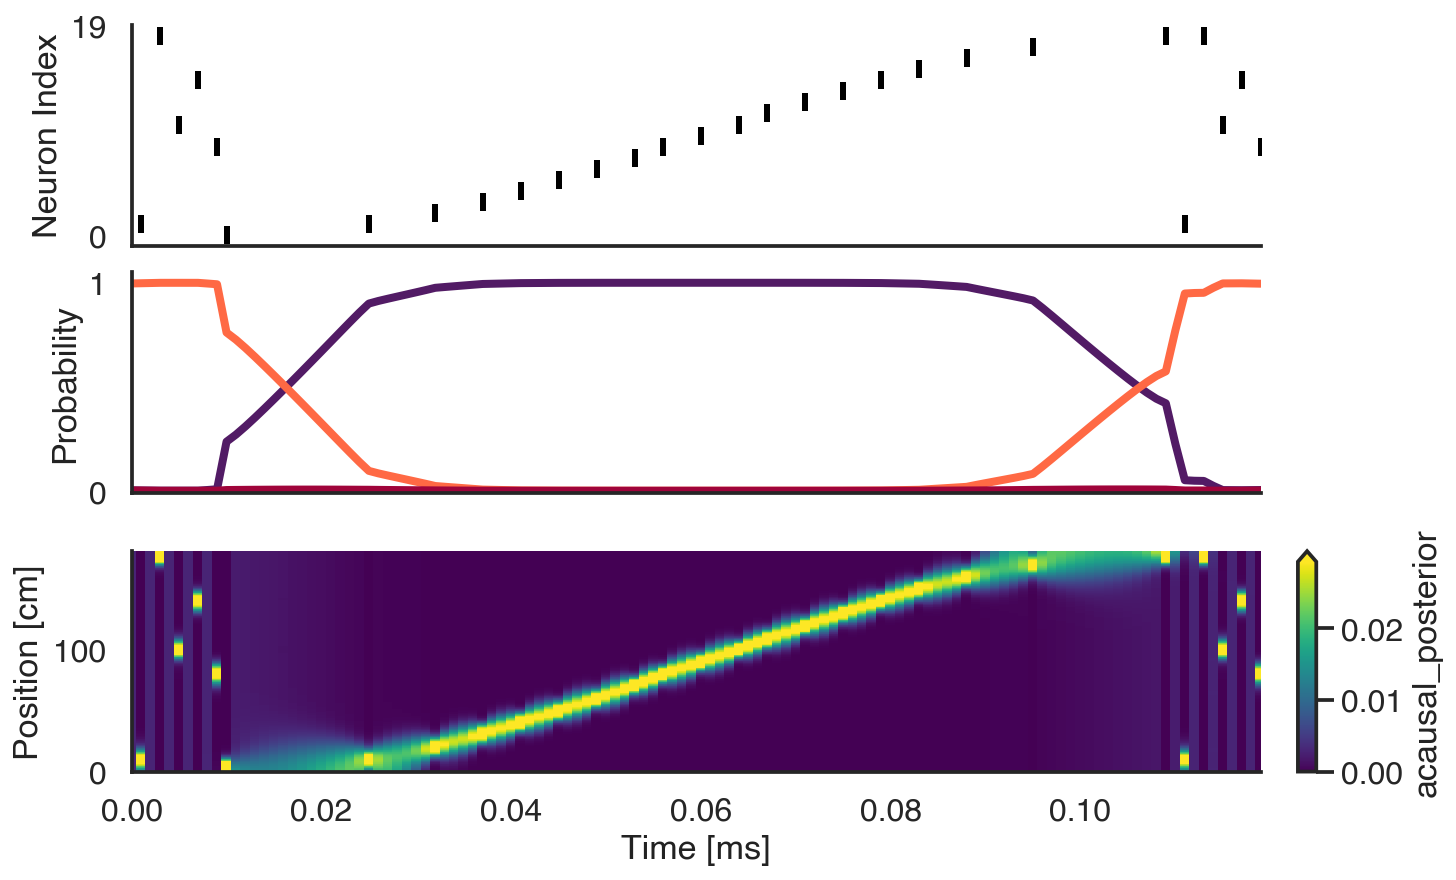

In [131]:
from src.sorted_spikes_simulation import make_fragmented_continuous_fragmented_replay

replay_time, test_spikes = make_fragmented_continuous_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time)
plot_classification(replay_time, test_spikes, results)

save_figure('simulated_spikes_fragmented_continuous_fragmented_replay', is_save_figures)

## Explore State Transition Parameters on Hover-Continuous-Hover

In [91]:
replay_time, test_spikes = make_hover_continuous_hover_replay()

def plot_replay_probability(replay_time, results, diag, add_legend=True):
    results = results.assign_coords(
        state=lambda ds: ds.state.to_index()
        .map(TRANSITION_TO_CATEGORY))
    fig, ax = plt.subplots(1, 1, figsize=(10, 3), constrained_layout=True, sharex=True)
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        ax.plot(prob.time, prob.values, linewidth=4, label=state, color=STATE_COLORS[state])
    ax.set_ylabel('Probability')
    ax.set_ylim((-0.01, 1.05))
    if add_legend:
        ax.legend(bbox_to_anchor=(1.15, 0.95), loc='upper right', fancybox=False, shadow=False,
                  ncol=1, frameon=False)

    plt.title(f'discrete state transition diagonal = {diag}', fontsize=16)
    sns.despine()

### All states equally likely

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


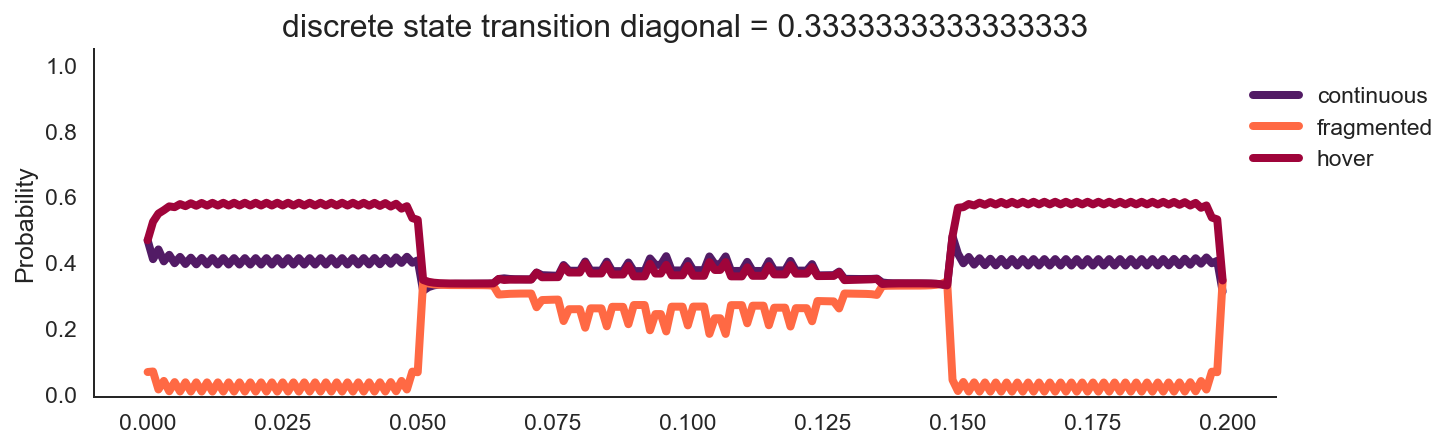

In [69]:
diag = 1/3

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    place_bin_size=np.sqrt(movement_var),
                                    continuous_transition_types=continuous_transition_types,
                                    discrete_transition_diag=diag)
classifier.fit(linear_distance, spikes)
results = classifier.predict(test_spikes, replay_time)
plot_replay_probability(replay_time, results, diag)

### Test diagonal strength from 0.4 - 0.9

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:

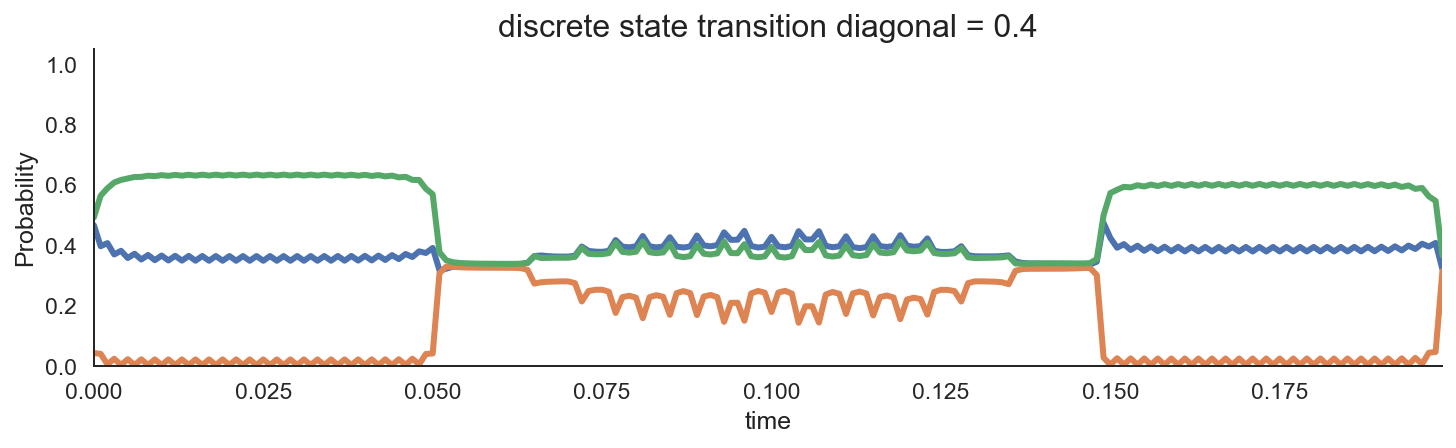

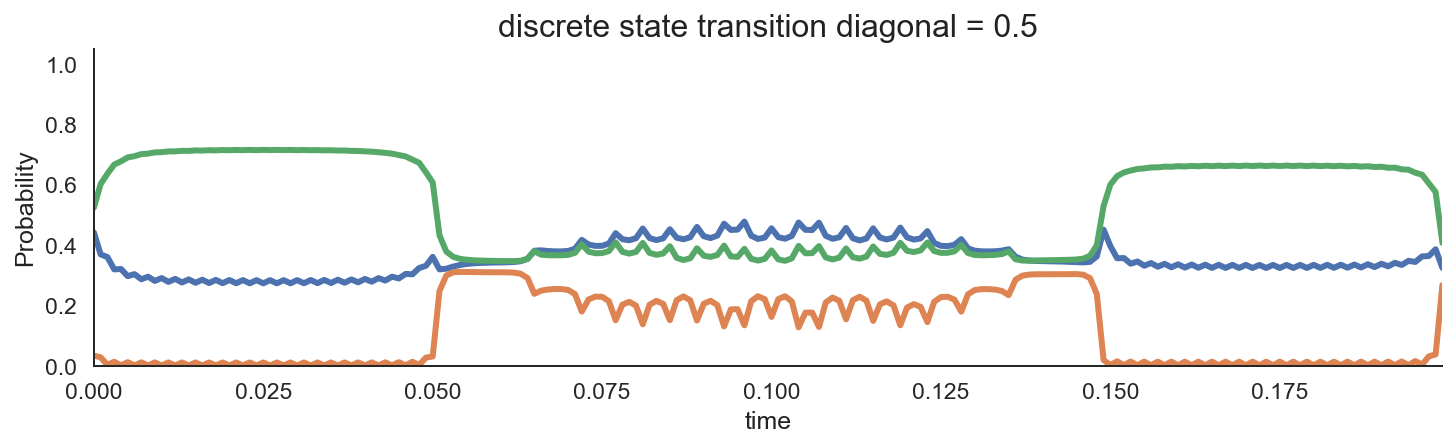

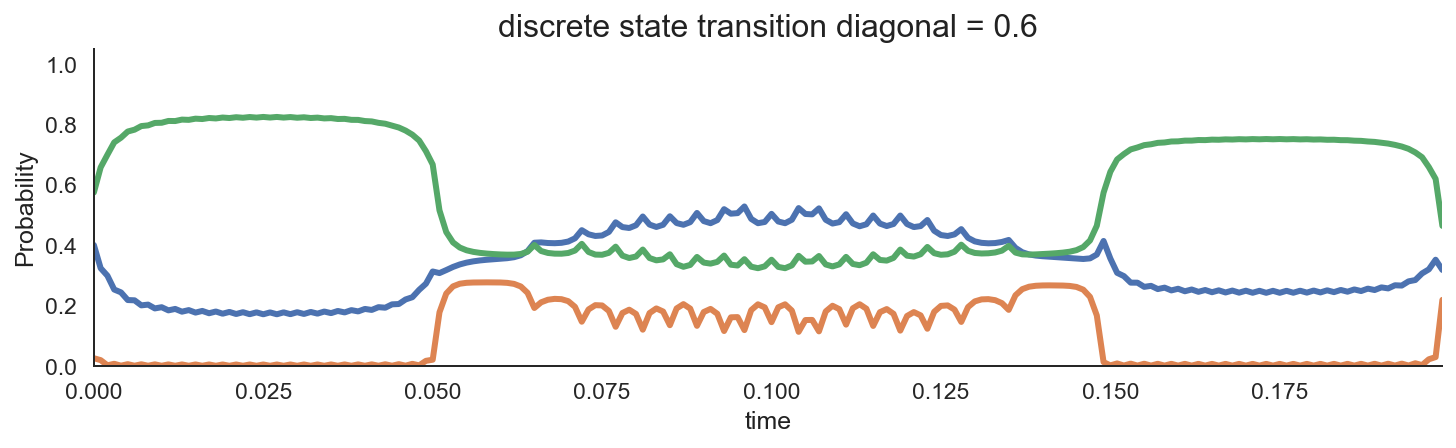

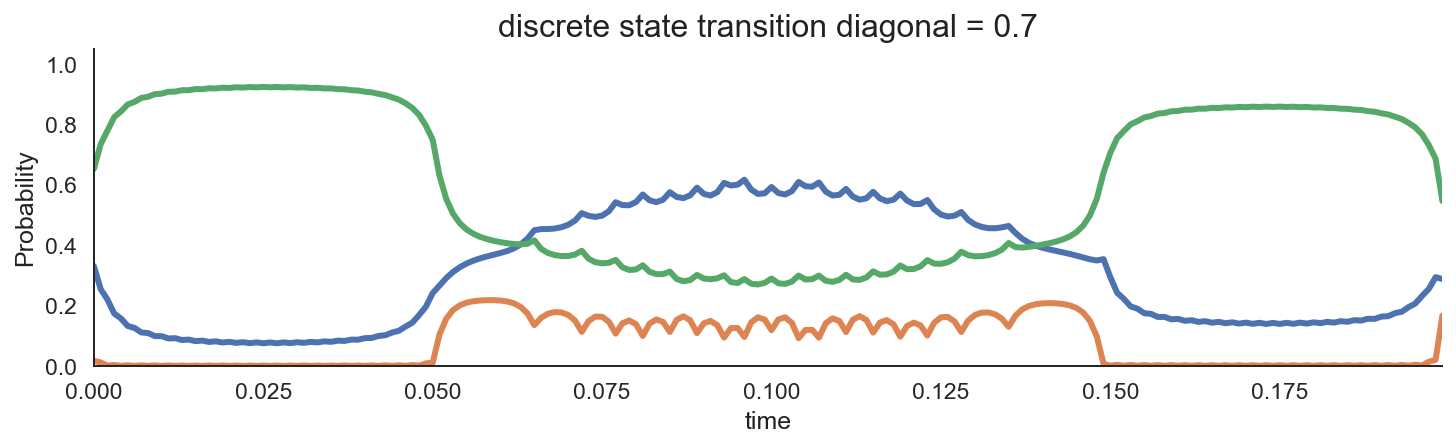

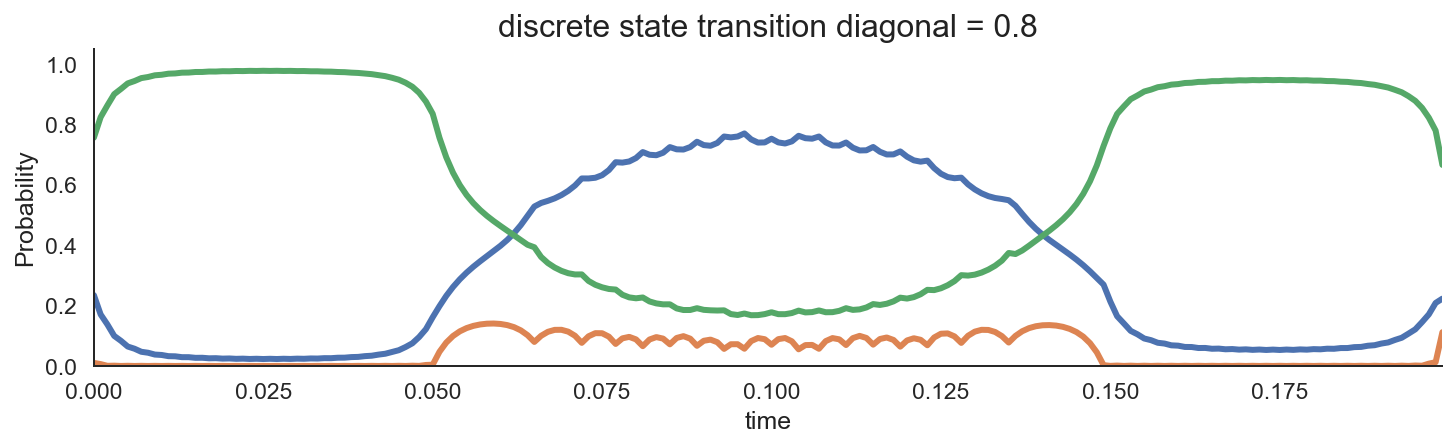

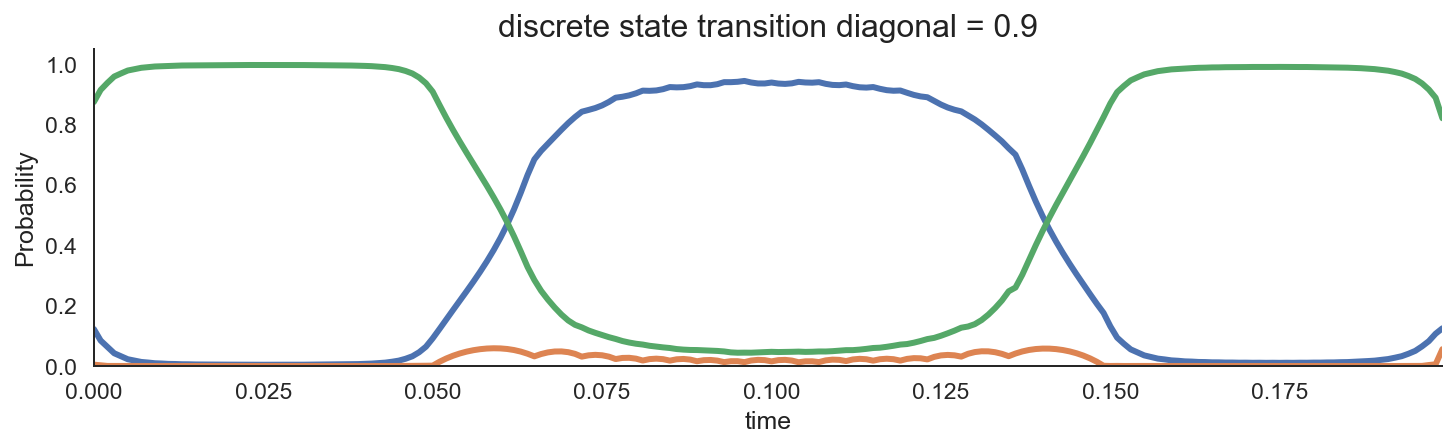

In [17]:
diags = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for diag in diags:
    classifier = SortedSpikesClassifier(movement_var=movement_var,
                                        replay_speed=120,
                                        spike_model_penalty=0.5,
                                        place_bin_size=np.sqrt(movement_var),
                                        continuous_transition_types=continuous_transition_types,
                                        discrete_transition_diag=diag)
    classifier.fit(linear_distance, spikes)
    results = classifier.predict(test_spikes, replay_time)
    plot_replay_probability(replay_time, results, diag)

### Test diagonal strength from 0.99 - 0.999999999

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:

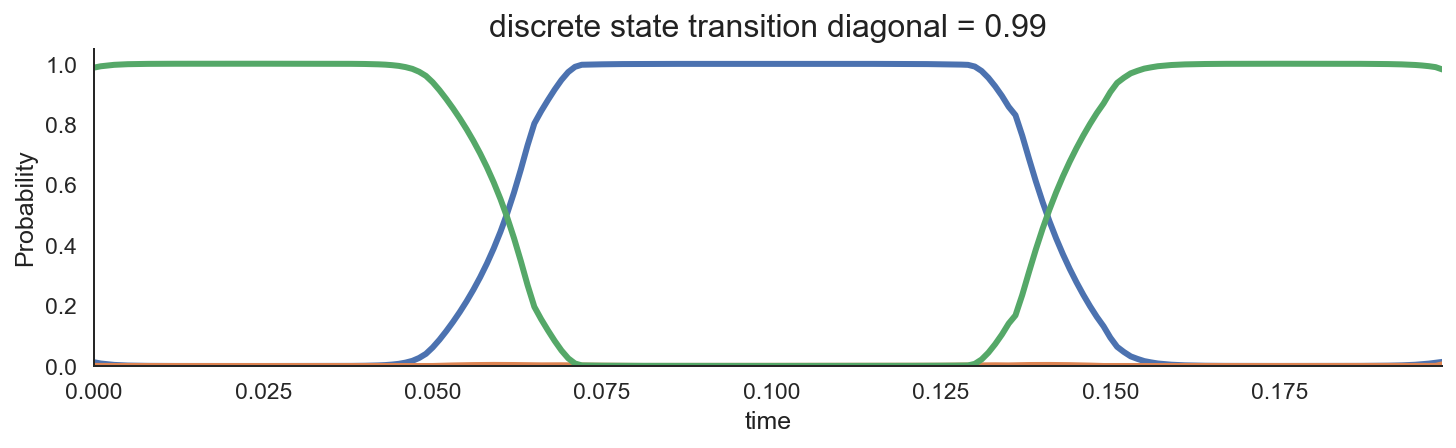

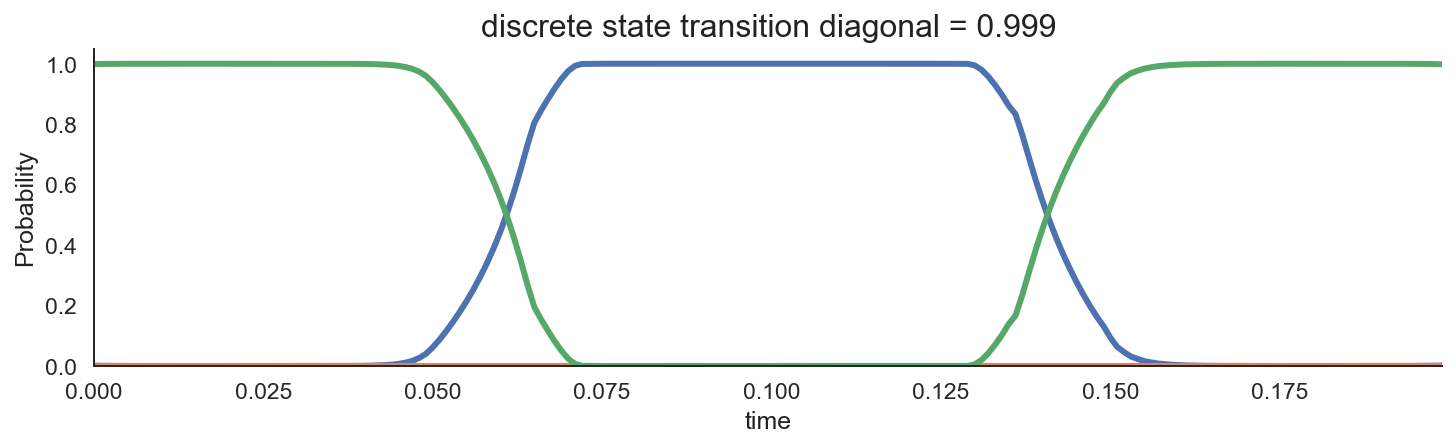

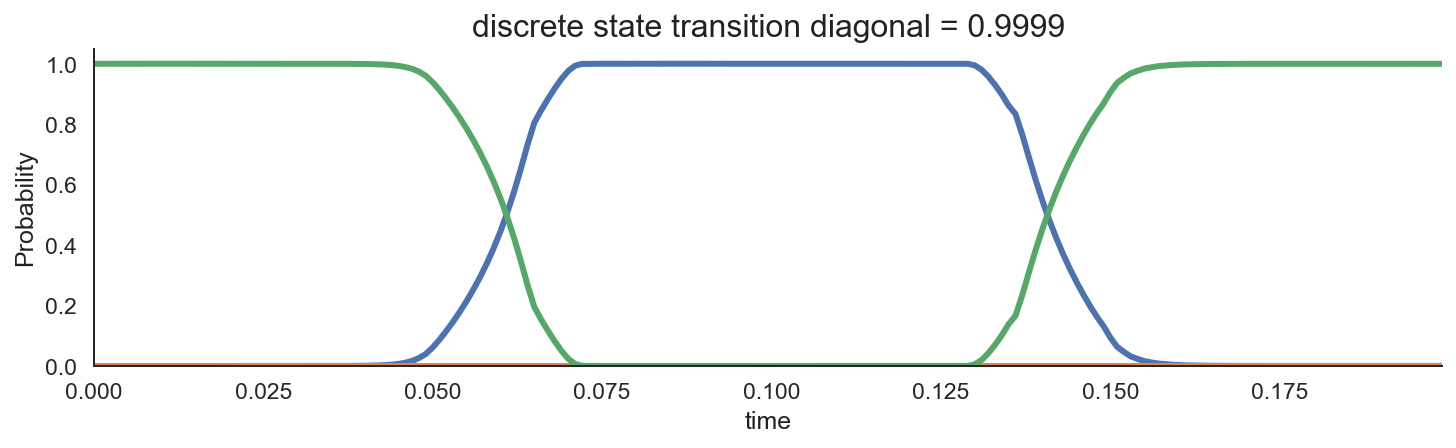

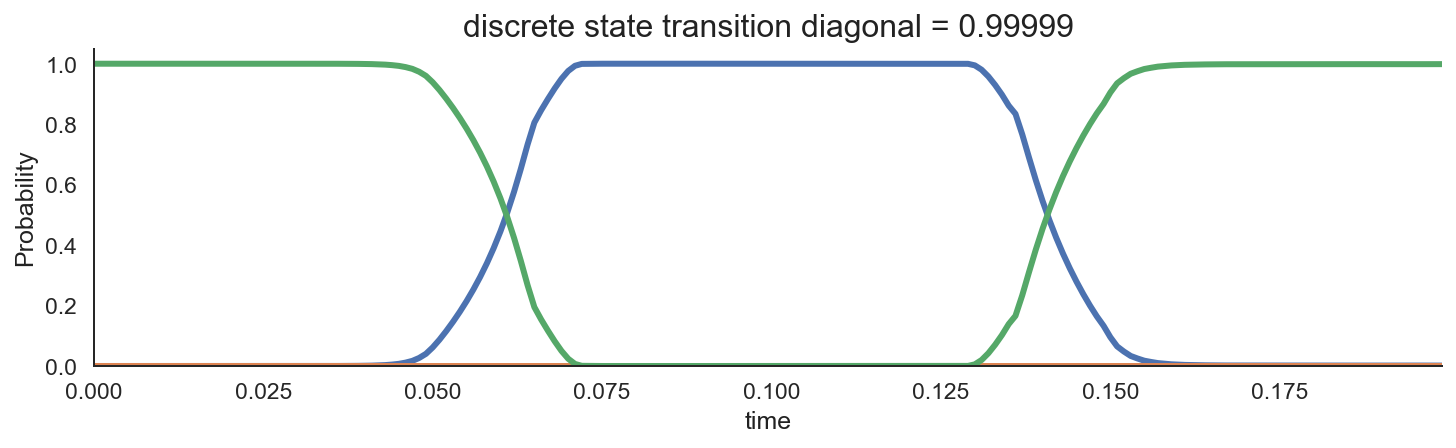

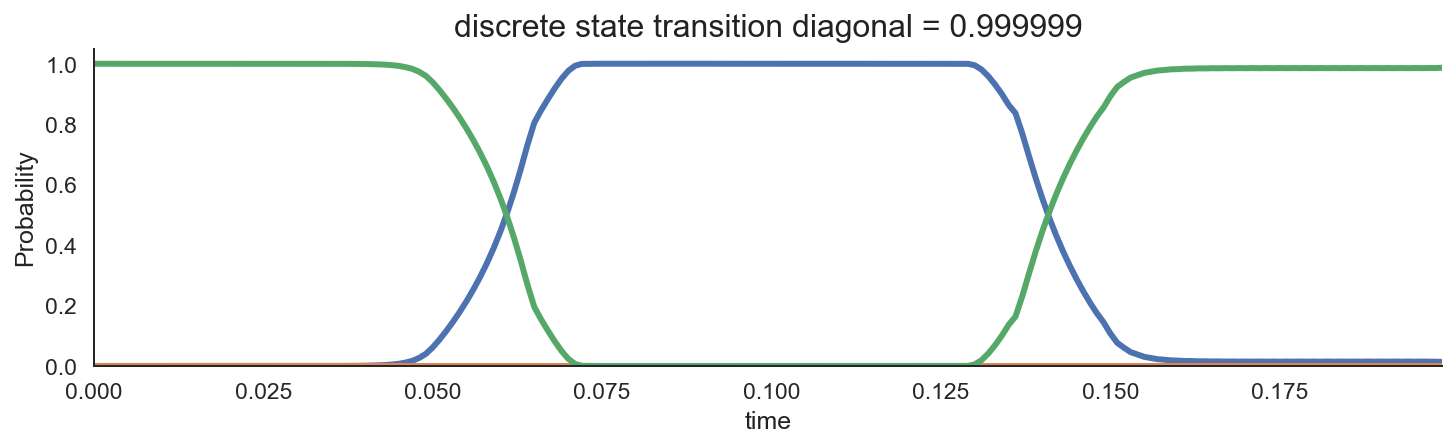

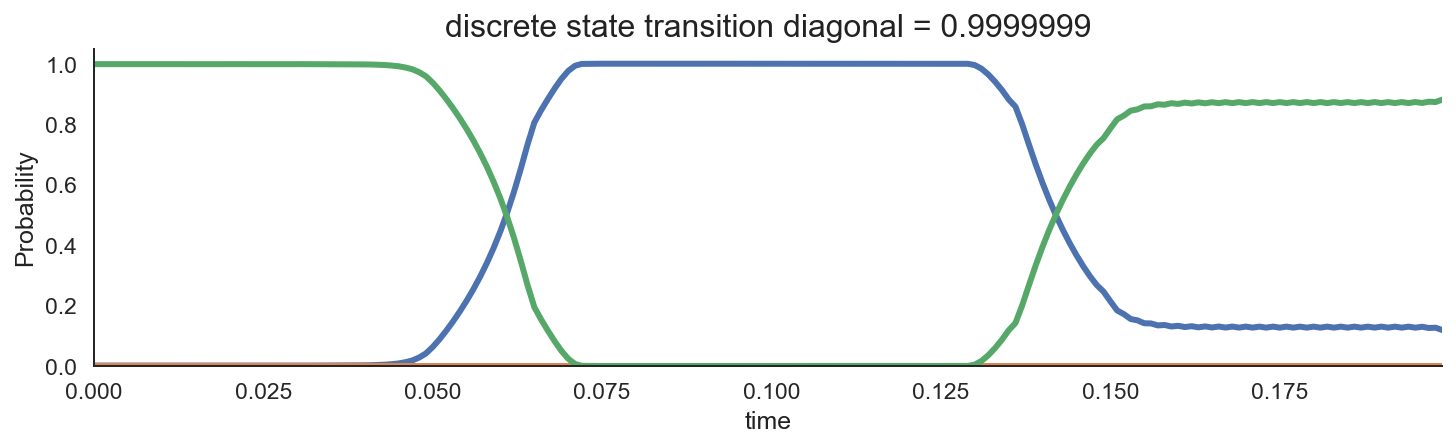

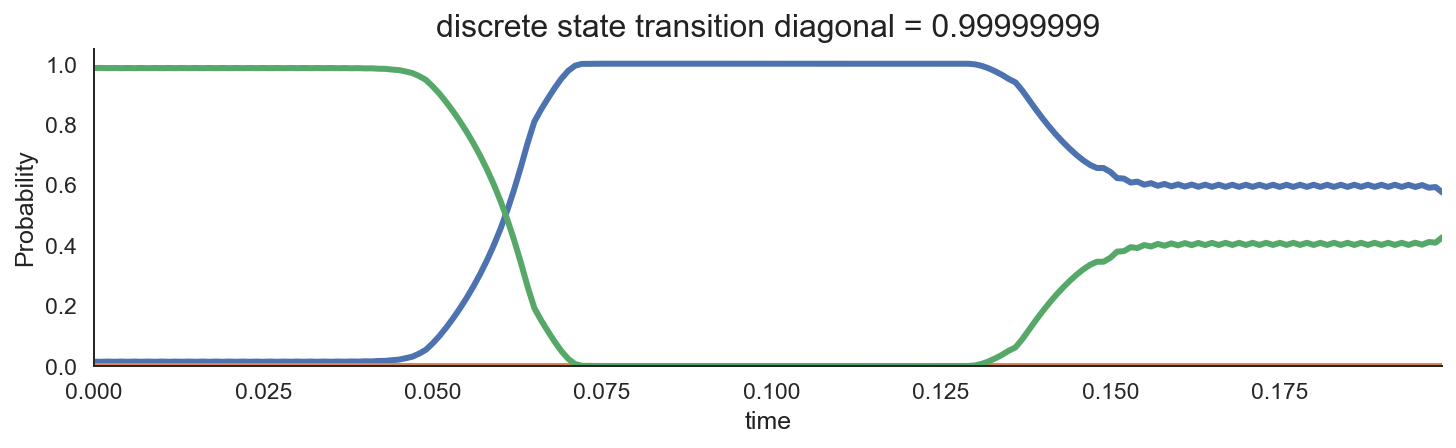

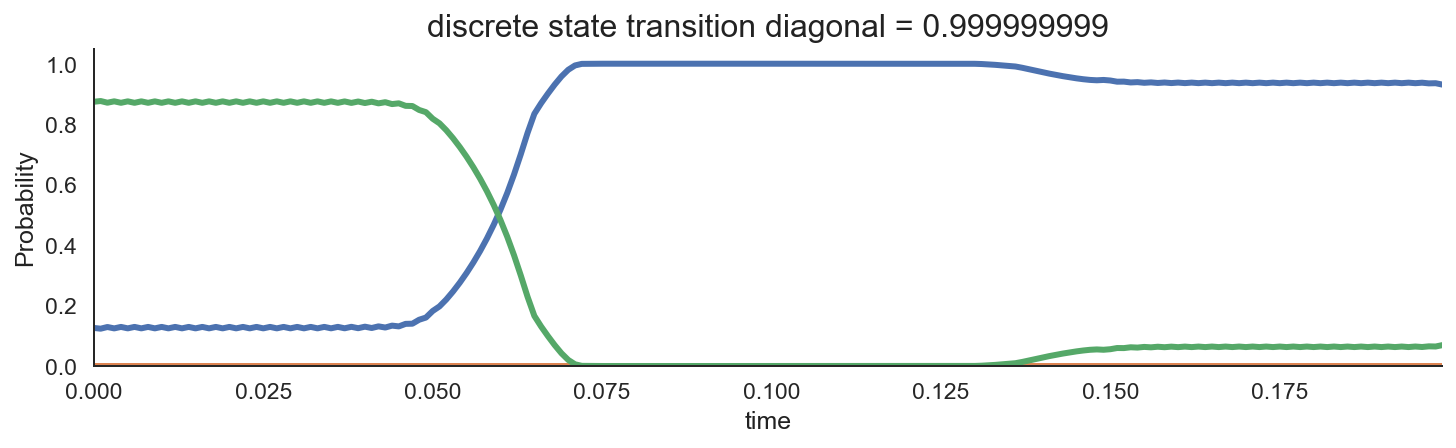

In [18]:
diags = [(1 - 10 ** -n) for n in range(2, 10)]

for diag in diags:
    classifier = SortedSpikesClassifier(movement_var=movement_var,
                                        replay_speed=120,
                                        spike_model_penalty=0.5,
                                        place_bin_size=np.sqrt(movement_var),
                                        discrete_transition_diag=diag)
    classifier.fit(linear_distance, spikes)
    results = classifier.predict(test_spikes, replay_time)
    plot_replay_probability(replay_time, results, diag)

### Not allowing transitions between states

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


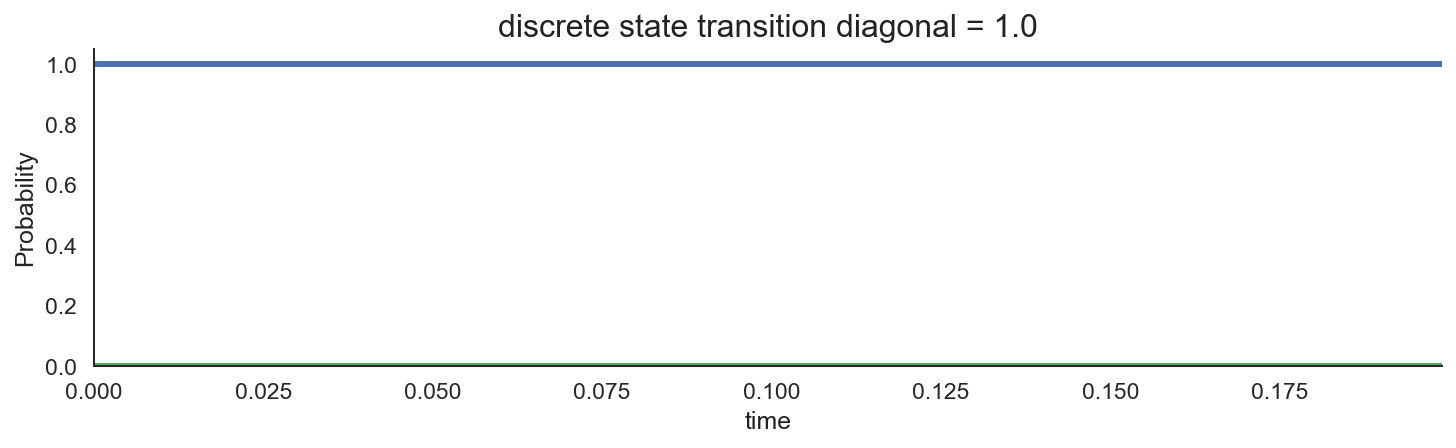

In [19]:
diag = 1.0

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    spike_model_penalty=0.5,
                                    place_bin_size=np.sqrt(movement_var),
                                    discrete_transition_diag=diag)
classifier.fit(linear_distance, spikes)
results = classifier.predict(test_spikes, replay_time)
plot_replay_probability(replay_time, results, diag)

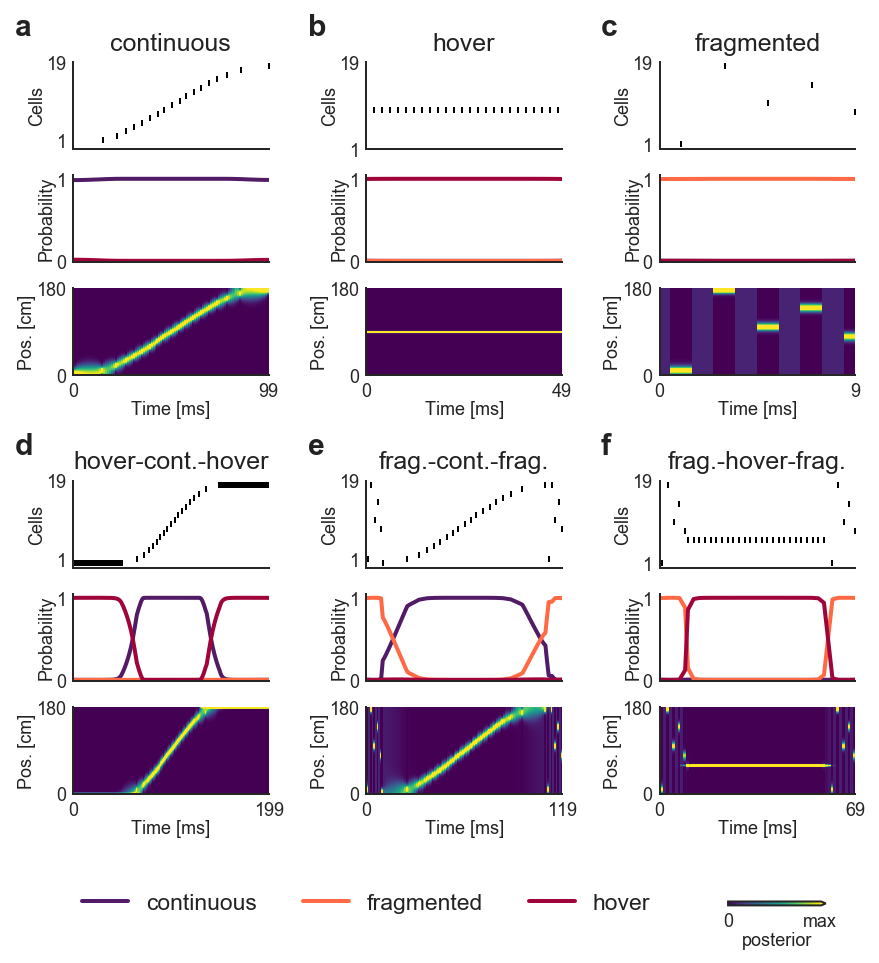

In [625]:
import matplotlib.gridspec as gridspec
from src.figure_utilities import TWO_COLUMN, GOLDEN_RATIO, PAGE_HEIGHT, save_figure, set_figure_defaults

from src.parameters import TRANSITION_TO_CATEGORY, STATE_COLORS
import string

set_figure_defaults()

def plot_classification(test_spikes, results, subplot_spec, fig, replay_name,
                        letter):
    results = results.assign_coords(
        state=lambda ds: ds.state.to_index()
        .map(TRANSITION_TO_CATEGORY),
        time=lambda ds: ds.time * 1000.0,
    )
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    replay_time = results.time.values
    
    inner_grid = gridspec.GridSpecFromSubplotSpec(
        nrows=3, ncols=1, subplot_spec=subplot_spec, hspace=0.3)
    
    # Spikes
    ax = plt.Subplot(fig, inner_grid[0])
    ax.scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=10, linewidth=1)
    ax.set_yticks((1, test_spikes.shape[1]))
    ax.set_xticks([])
    ax.set_xlim((replay_time.min(), replay_time.max()))
    ax.set_ylabel('Cells')
    ax.text(-0.3, 1.3, letter, transform=ax.transAxes,
            size=15, weight='bold')
    ax.set_title(replay_name)
    fig.add_subplot(ax)
    
    # Probability
    ax = plt.Subplot(fig, inner_grid[1])
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        ax.plot(prob.time, prob.values, linewidth=2, label=state, color=STATE_COLORS[state])
    ax.set_ylabel('Probability')
    ax.set_yticks([0, 1])
    ax.set_xticks([])
    ax.set_xlim((replay_time.min(), replay_time.max()))
    ax.set_ylim((-0.01, 1.05))
    fig.add_subplot(ax)
    legend_handle, legend_labels = ax.get_legend_handles_labels()
    
    # Posterior
    ax = plt.Subplot(fig, inner_grid[2])
    quad_mesh = results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=ax,
        add_colorbar=False, rasterized=True)
    ax.set_ylabel('Pos. [cm]')
    ax.set_xlim((replay_time.min(), replay_time.max()))
    ax.set_xticks((replay_time.min(), replay_time.max()))
    ax.set_yticks((0.0, 180.0))
    ax.set_xlabel('Time [ms]')
    fig.add_subplot(ax)
    
    sns.despine()
    
    return legend_handle, legend_labels, quad_mesh

fig = plt.figure(figsize=(TWO_COLUMN, PAGE_HEIGHT * 0.8), constrained_layout=True)
outer_grid = fig.add_gridspec(nrows=3, ncols=3, height_ratios=[1, 1, 0.025], wspace=0.5, hspace=0.5)
replay_types = [
    ('continuous', make_continuous_replay),
    ('hover', make_hover_replay),
    ('fragmented', make_fragmented_replay),
    ('hover-cont.-hover', make_hover_continuous_hover_replay),
    ('frag.-cont.-frag.', make_fragmented_continuous_fragmented_replay),
    ('frag.-hover-frag.', make_fragmented_hover_fragmented_replay)
]

for replay_ind, (replay_name, make_replay) in enumerate(replay_types):
    replay_time, test_spikes = make_replay()
    results = classifier.predict(test_spikes, time=replay_time)
    letter = string.ascii_lowercase[replay_ind]
    legend_handle, legend_labels, g = plot_classification(test_spikes, results,
                        outer_grid[replay_ind], fig, replay_name, letter)

legend_ax = fig.add_subplot(outer_grid[-1, :2])
legend_ax.axis('off')
legend_ax.legend(legend_handle, legend_labels, loc='center',
                 fancybox=False, shadow=False, ncol=3, frameon=False,
                 bbox_to_anchor=(0.1, 0, 1, 1))

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
colorbar_ax = fig.add_subplot(outer_grid[-1, -1])
colorbar_ax.axis('off')
axins = inset_axes(colorbar_ax,
                   width="50%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   bbox_transform=colorbar_ax.transAxes,
                   borderpad=0,
                   loc='center',
                   bbox_to_anchor=(0.1, 0, 1, 1),
                   )
cbar = plt.colorbar(g, cax=axins, orientation='horizontal',
                    extend='max', label='posterior',
                    ticks=[0.0, 0.035])
cbar.ax.set_xticklabels(['0', 'max'])
cbar.ax.tick_params(width=0, length=0)

# save_figure('Figure3')

In [576]:
GOLDEN_RATIO

0.6180339887498949

In [631]:
from dask.distributed import Client

client = Client(processes=False)
replay_time, test_spikes = make_hover_continuous_hover_replay()
diags = ([1/3] +
         [0.4, 0.5, 0.6, 0.7, 0.8, 0.9] + 
         [(1 - 10 ** -n) for n in range(2, 10)] +
         [1])

results = []

for diag in diags:
    classifier = SortedSpikesClassifier(movement_var=movement_var,
                                        replay_speed=120,
                                        spike_model_penalty=0.5,
                                        place_bin_size=np.sqrt(movement_var),
                                        discrete_transition_diag=diag)
    classifier.fit(linear_distance, spikes)
    results.append(classifier.predict(test_spikes, replay_time))

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:

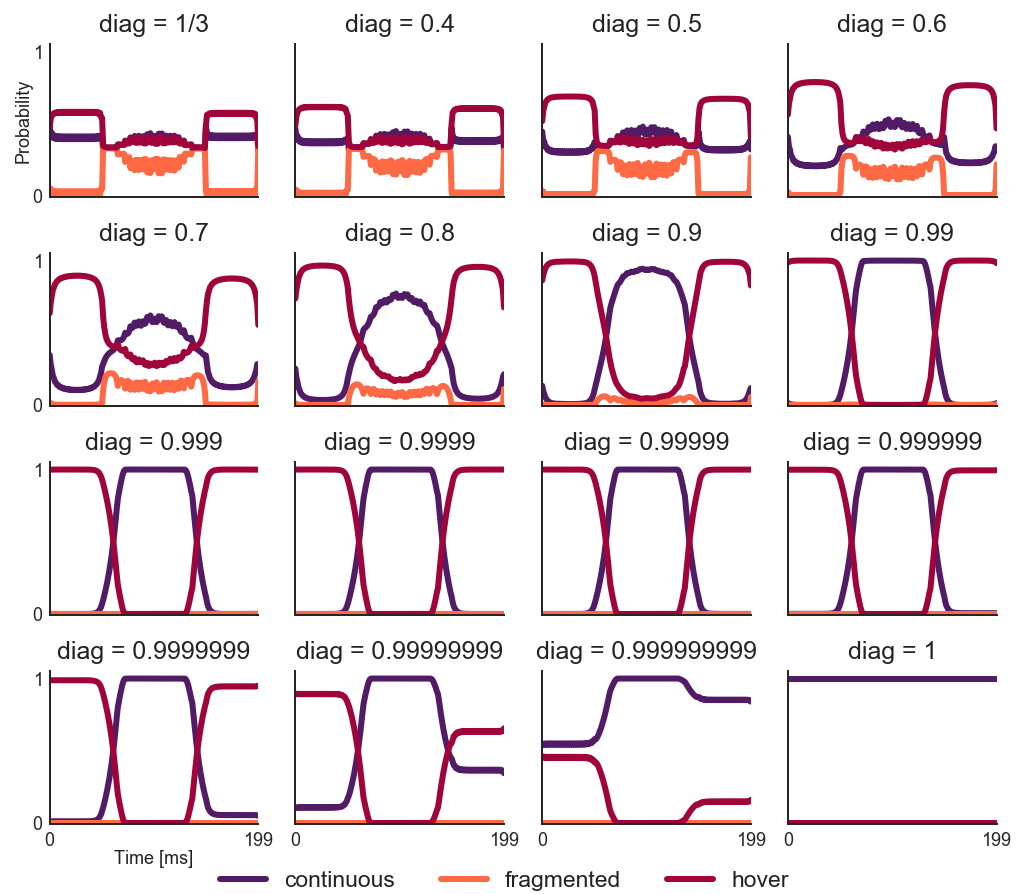

In [655]:
def plot_replay_probability(results, diag, ax):
    results = results.assign_coords(
        state=lambda ds: ds.state.to_index()
        .map(TRANSITION_TO_CATEGORY),
        time=lambda ds: ds.time * 1000
    )
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        ax.plot(prob.time, prob.values, linewidth=3, label=state, color=STATE_COLORS[state])
    ax.set_ylim((-0.01, 1.05))
    ax.set_yticks([0, 1])
    ax.set_xlim((results.time.min(), results.time.max()))
    ax.set_xticks([results.time.min(), results.time.max()])
    if np.allclose(diag, 1/3):
        ax.set_title(f'diag = 1/3')
    else:
        ax.set_title(f'diag = {diag}')

fig, axes = plt.subplots(4, 4, figsize=(TWO_COLUMN, PAGE_HEIGHT * GOLDEN_RATIO),
                         constrained_layout=True, sharex=True, sharey=True)

for ind, (ax, diag, r) in enumerate(zip(axes.flat, diags, results)):
    plot_replay_probability(r, diag, ax)
axes[0, 0].set_ylabel('Probability')
axes[3, 0].set_xlabel('Time [ms]')

legend_handle, legend_labels = ax.get_legend_handles_labels()
fig.legend(legend_handle, legend_labels, loc='lower center',
           fancybox=False, shadow=False, ncol=3, frameon=False,
           bbox_to_anchor=(0.5, -0.02)
           )
sns.despine()
save_figure('Supplemental_Figure3')
save_figure('Supplemental_Figure3', 'png')